# Diferentes tipos de entrenamiento y test

Hemos visto en los notebook anteriores lo sencillo que resulta usar un algoritmo de ML para generar unas predicciones o incluso, lo fácil que resulta probar diferentes modelos gracias al interfaz común scikit-learn.

Evidentemente, no hemos prestado atención a los detalles acerca del entrenamiento del modelo o de cómo deberíamos ajustar los diferentes hiperparámetros de los modelos. Inicialmente se han usado todos los datos disponibles para entrenar el modelo. 

PREGUNTA: ¿Es esto una buena idea?, ¿por qué?




A continuación, veremos una mejora a esta aproximación

## Entrenar el modelo con todos los datos disponibles

In [ ]:
from rich import print

from sklearn.datasets import load_iris
import numpy as np

dataset_iris = load_iris()
print(dataset_iris)

In [ ]:
datos = dataset_iris.data
salida = dataset_iris.target

disponer de una parte de los datos para entrenar el modelo y otra, para validarlo, supone una primera aproximación para comprobar la capacidad de generalización del modelo. Lo estaremos validando con datos desconocidos para el modelo.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
ml_knn = KNeighborsClassifier()
ml_knn.fit(datos,salida)
ml_knn_predictions = ml_knn.predict(datos)
print(ml_knn_predictions)

In [ ]:
len(ml_knn_predictions)

hemos entrenado un modelo knn con un conjunto de datos que tiene 150 observaciones y 4 variables. Una vez entrenado, hemos usado el modelo para predecir esas mismas observaciones y se obtienen 150 predicciones. 

PREGUNTA: ¿Alguien me sabria decir si el modelo lo ha hecho bien?

In [ ]:
from sklearn import metrics
print(metrics.accuracy_score(salida,ml_knn_predictions))

este resultado es el accuracy en entrenamiento (en el siguiente notebook trataremos las medidas de rendimiento de los diferentes modelos de ML). Hemos entrenado el modelo con unos datos y los hemos vuelto a usar todos para ver qué tal ha hecho la clasificación.

el objetivo final de la fase de entrenamiento de un modelo es saber si será capaz de generalizar la información que extrae de los datos. 

PREGUNTA: Entonces, ¿es recomendable hacer lo que hemos hecho?

## Dividir los datos en *training* y *test*

Una mejor aproximación consiste en dividir nuestro conjunto de datos inicial en dos conjuntos, uno se usará para entrenar el modelo y otro se dejará fuera de todo el proceso (desconocido para el modelo). De esta manera siempre contaremos con un conjunto de datos que no ha sido visto por el modelo para comprobar la capacidad de generalización del mismo usando datos desconocidos.

scikit-learn nos echa una mano para esto con el método `train_test_split`.

In [ ]:
from sklearn.model_selection import train_test_split
datos_entrenamiento, datos_test, salida_entrenamiento, salida_test = train_test_split(datos,salida,test_size=0.2,stratify=salida,random_state=42)

PREGUNTAS: ¿para qué sirve el parámetro stratify? y ¿el parámetro random_state?

In [ ]:
datos.shape

In [ ]:
datos_entrenamiento.shape

In [ ]:
datos_test.shape

In [ ]:
type(salida_test)

In [ ]:
np.unique(salida_test,return_counts=True)

In [ ]:
from sklearn.model_selection import train_test_split
datos_entrenamiento, datos_test, salida_entrenamiento, salida_test = train_test_split(datos,salida,test_size=0.5)
np.unique(salida_test,return_counts=True)

PREGUNTA: ¿cuál es el proceso real que ha hecho la función train_test_split?. Es decir, si os dijesen que hay que implementarlo, ¿qué tendriais que hacer? vamos a dibujar!!

In [ ]:
ml_knn = KNeighborsClassifier()
ml_knn.fit(datos_entrenamiento,salida_entrenamiento)
ml_knn_predictions_test = ml_knn.predict(datos_test)
print(metrics.accuracy_score(salida_test,ml_knn_predictions_test))

Como comentamos antes, si queremos generar un nuevo modelo con el hiperparámetro que mejor resultado obtenga, no hace falta ir probando de uno en uno. Bueno, si no tienes otra cosa que hacer y cobras por horas igual sí ;)

Vamos a hacer un primer nivel de automatización (posiblemente como hasta ahora, lo que vamos a hacer no sea la mejor opción). Aunque seguro que os sonará.

In [ ]:
hiper_k_rango = range(1,30)
scores=[]
for k in hiper_k_rango:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(datos_entrenamiento,salida_entrenamiento)
    salida_predicha = knn_model.predict(datos_test)
    scores.append(metrics.accuracy_score(salida_test,salida_predicha))

print(scores)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hiper_k_rango,scores)
plt.xlabel("Valores de k")
plt.ylabel("Accuracy en test")

En términos generales:
+ El accuracy en entrenamiento incrementa cuando incrementa la complejidad del modelo
+ Los modelos muy complejos para los datos analizados son penalizados en el accuracy de test

PREGUNTA: ¿por qué?

supongamos que ahora mismo hemos seguido la mejor aproximación posible para entrenar un modelo de ML. 

PREGUNTA: ¿qué modelo pondríamos en producción?

In [ ]:
scores[15]
knn_produccion = KNeighborsClassifier(n_neighbors=15)
knn_produccion.fit(datos,salida)
knn_produccion.predict([[2,5,4,3]])

### ¿Qué estamos haciendo realmente?

lo hemos dibujado hace un momento, pero vamos a implementarlo.

In [ ]:
import numpy as np
import pandas as pd

def own_split_train_test(data,ratio):
    indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*ratio)
    indices_test = indices[:test_set_size]
    indices_train = indices[test_set_size:]
    return data.iloc[indices_train], data.iloc[indices_test]

A continuación procederemos con la carga de una base de datos bastante conocida, que es la *California house pricing* sustitutas para muchos casos de la *Boston housing* otro problema muy conocido y estudiado dentro del aprendizaje automático. En este caso vamos a cargar los datos previamente a dividirlos y pasaremos un parametro especial `as_frame` a la función que lo permitirá que se carga un *dataframe* de pandas con todos los datos. Si no fuera así, se podría recrear el conjunto con el siguiente código:

```python
    housing_df = pd.DataFrame(housing.data, columns=housing.feature_names)

    housing_df['target'] = housing.target

```
A mayores imprimiremos del data set las claves las cuales, tal como se puede comprobar en la documentación incluyen:

- **data**, los datos/patrones del problema
- **target**, las salidas deseadas del problema.
- **frame**, solo disponible si se ha usado el parametro `as_frame`
- **target_names**, una lista de las posible salidas con valores categóricos
- **feature_names**, los nombres asociados a cada una de las variables/medidas de los patrones del problema.
- **DESC**, descripción del problema

Es de destacr que en este caso estamos usando datos ya preparados, un paso importante y que veremos en lecciones posteriores es la preparación de estos problemas para su uso independientemente, ya que nuestros datos nunca nos vendrán en este formarto.

In [ ]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing.keys()

Ahora procederemos a dividir los datos con nuestra función recien definida.

In [ ]:
datos_entrenamiento, datos_test = own_split_train_test(data=housing.frame,ratio=0.5)

housing.frame.shape

In [ ]:
datos_entrenamiento.shape

In [ ]:
datos_test.shape

PREGUNTA: ¿se os ocurre algo que puede no ser correcto del código que acabamos de ver?




Cada vez que llamemos a nuestra función, devolverá un conjunto de test diferente. Este no es un comportamiento que queramos. Si entrenamos suficientes veces (muchas) el modelo de ML podemos estar introduciendo un sesgo y ajustar demasiado los modelos a los conjuntos que nos interesan. Este es el motivo por el que la función de scikit-learn añade random_state None por defecto. A veces se ven opciones del tipo random_state=42. El número 42 no tiene nada de especial, pero de alguna manera se ha convertido tradicionalmente en el que se usa.

muy importante, a veces estamos en entorno interactivo e incluso en jupyter o en consola y nos gustaría obtener información de la función que vamos a usar, en Python podemos consultar dicha información con las siguientes sentencias.

In [ ]:
import inspect
lines = inspect.getsource(train_test_split)
print(lines)

En términos generales:
+ Los modelos entrenados con la técnica de dividir los datos en dos (entrenamiento, test) tienden a generar modelos con resultados muy variables (inestables). Dichos modelos no son buenos modelos para poner en producción.
+ Sin embargo, esta aproximación sí que nos lleva a poder enteder un modelo **k-fold cross-validation**
+ Podría considerarse útil para una primera aproximación rápida y flexible y sabiendo que tiende a sobrestimar los resultados.
+ NO se puede usar el dataset de test nunca y para nada en ningún momento. PREGUNTA: ¿Por qué?
+ se utilizan métodos de *sampling* puramente aleatorios, y esto está bien si tenemos datos suficientes en el dataset, especialmente en el número de features, no de ejemplos. En caso de hacer un *sampling* aleatorio se ha demostrado que existe aproximadamente un 20% de probabilidades de meter un *sesgo* en los datos que no existía previamente.

## k-fold cross-validation
una vez vistas las limitaciones del reparto de las observaciones en dos conjuntos (entrenamiento y test), vamos a ver una mejor aproximación que va a permitir a los modelos generalizar en condiciones más estables y seguras.

vamos a cambiar de dataset y a buscar uno con un poco más de dificultad. En este caso es el de 

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

bc = load_breast_cancer()

datos = bc.data
salida = bc.target

datos_train, datos_test, salida_train, salida_test = train_test_split(datos, salida, random_state=42, stratify=salida,test_size=0.4)

knn_model = KNeighborsClassifier()
knn_model.fit(datos_train, salida_train)
salida_predicha = knn_model.predict(datos_test)
print(metrics.accuracy_score(salida_test,salida_predicha))

### Fases de un k-fold cross-validation
1. Divide el dataset en **k** grupos de igual tamaño
2. Usa el primer fold para test y todos los demás juntos para entrenar el modelo
3. Calcula el accuracy en test
4. Repite los pasos 2 y 3 **k** veces, utilizando como fold de validación una vez cada uno de los folds
4. Calcula el rendimiento global al final del proceso. Existen dos aproximaciones:
    + hacer la media de todos los folds
    + una aproximación más purista o respetuosa con el ML extraería la salida esperada y la salida predicha (vectores) de cada uno de los folds, reconstruiría el *vector grande* y calcularía el resultado.
    
Vamos a pintarlo!!

el gráfico final de un proceso de cross-validation es el siguiente 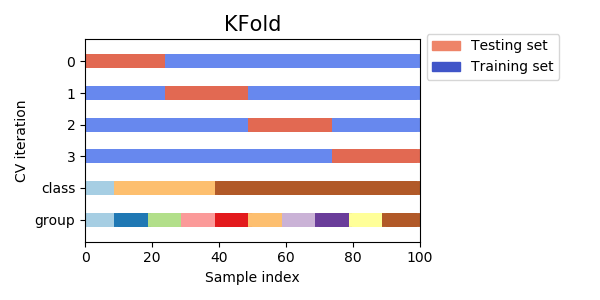

In [ ]:
from sklearn.model_selection import KFold
X = np.random.rand(30,10)
y = np.random.rand(30,1)
kf = KFold(n_splits=4)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]


PREGUNTA: ¿le veis algún problema?

In [ ]:
from sklearn.model_selection import KFold
X = np.random.rand(30,10)
y = np.random.rand(30,1)
kf = KFold(n_splits=4,shuffle=True)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

vamos a entrenar nuestro primer modelo con 10-fold cross validation

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

bc = load_breast_cancer()

datos = bc.data
salida = bc.target

knn_model = KNeighborsClassifier()

resultados_kfold = cross_val_score(knn_model,datos,salida,cv=10,scoring='accuracy')

print(resultados_kfold.mean())

Idealmente, ahora podríamos buscar el mejor valor de K igual que antes, pero con modelos entrenados siguiendo un 10-fold cross-validation. Ajustando el código anterior:

In [ ]:
hiper_k_rango = range(1,30)
scores=[]
for k in hiper_k_rango:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    resultados_kfold = cross_val_score(knn_model,datos,salida,cv=10,scoring='accuracy')
    scores.append(resultados_kfold.mean())

print(scores)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hiper_k_rango,scores)
plt.xlabel("Valores de k")
plt.ylabel("Accuracy en 10-fold cross-validation")

ahora podemos hacer una afirmación del tipo el modelo knn es mejor que otro modelo. 

PREGUNTA: ¿con esto ya hemos terminado de mejorar el experimento CV?

#### Mejoras al k-fold cross-validation
el objetivo es conseguir modelos capaces de generalizar lo mejor posible, y una buena señal de que esto está ocurriendo es si la varianza observada de los resultados se estabiliza. Se observó una mejora entre la aproximación inicial y el 10-fold CV

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold,cross_val_score,RepeatedKFold,RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

bc = load_breast_cancer()

datos = bc.data
salida = bc.target

knn_model = KNeighborsClassifier()

RKFold = RepeatedKFold(n_splits=10,n_repeats=50)
resultados_RKfold = cross_val_score(knn_model,datos,salida,cv=RKFold,scoring='accuracy')

print(resultados_kfold.mean())

In [ ]:
from matplotlib.pyplot import boxplot
boxplot(resultados_kfold)

PREGUNTA: ¿qué tal el modelo?

las diferencias en función de la variabilidad se podrían ver de la siguiente forma 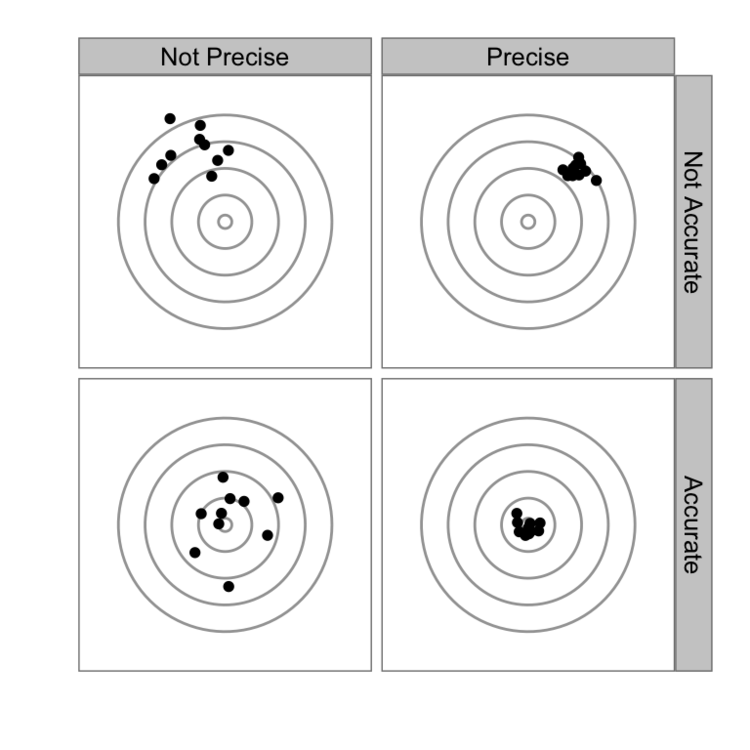

In [ ]:
hiper_k_rango = range(1,30)
scores=[]
for k in hiper_k_rango:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    resultados_kfold = cross_val_score(knn_model,datos,salida,cv=RKFold,scoring='accuracy')
    scores.append(resultados_kfold.mean())

print(scores)

In [ ]:
boxplot(scores)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hiper_k_rango,scores)
plt.xlabel("Valores de k")
plt.ylabel("Accuracy en 50 repeticiones 10-fold cross-validation")

In [ ]:
hiper_k_rango = range(1,30)
scores=[]
RKFold.stratified = RepeatedStratifiedKFold(n_splits=10,n_repeats=50)

for k in hiper_k_rango:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    resultados_kfold = cross_val_score(knn_model,datos,salida,cv=RKFold.stratified,scoring='accuracy')
    scores.append(resultados_kfold.mean())
    
scores_media_Kfold = scores

print(scores)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hiper_k_rango,scores)
plt.xlabel("Valores de k")
plt.ylabel("Accuracy en 50 repeticiones 10-fold cross-validation")

anteriormente se había mencionado que hay que tener mucho cuidado y ser muy prudente cuando usemos cualquier tipo de librería o de API. El método *RepeatedKFold* devuelve la media de las repeticiones para cada fold, no para cada experimento. Podemos crearnos nuestra propia función:

In [ ]:
import numpy as np
from sklearn.utils import shuffle

def cross_validate(model, x, y, folds=10, repeats=5):
    ypred = np.zeros((len(y),repeats))
    score = np.zeros(repeats)
    x = np.array(x)
    for r in range(repeats):
        i=0
        print('Experimento número', str(r + 1), 'de', str(repeats))
        x,y = shuffle(x,y,random_state=r) 
        kf = KFold(n_splits=folds,random_state=i+1000,shuffle=True)
        for train_ind,test_ind in kf.split(x):
            print('Fold', i+1, 'de',folds)
            xtrain,ytrain = x[train_ind,:],y[train_ind]
            xtest,ytest = x[test_ind,:],y[test_ind]
            model.fit(xtrain, ytrain)
            ypred[test_ind,r]=model.predict(xtest)
            i+=1
        score[r] = metrics.accuracy_score(ypred[:,r],y)
        print('\nAccuracy del experimento:',str(score[r]))
    print('\nAccuracy:',str(score))
    print('Media:',str(np.mean(score)))
    print('Desviación:',str(np.std(score)))
    return score
    pass

score=cross_validate(knn_model, datos, salida, folds=10, repeats=5)

In [ ]:
boxplot(score)

PREGUNTA: ¿qué tal lo ha hecho el modelo? el boxplot es bastante grande, ¿no?

In [ ]:
hiper_k_rango = range(1,30)
scores=[]

for k in hiper_k_rango:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    resultados_kfold = cross_validate(knn_model, datos, salida, folds=10, repeats=5)
    scores.append(resultados_kfold.mean())

scores_vectores_kfold = scores    

print(scores)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hiper_k_rango,scores)
plt.xlabel("Valores de k")
plt.ylabel("Accuracy en 50 repeticiones 10-fold cross-validation")

In [ ]:
data = [scores_media_Kfold, scores_vectores_kfold]

fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data)


In [ ]:
type(data)

In [ ]:
import pandas as pd
df=pd.DataFrame(data).T
df.describe()

# Resumiendo:
+ los modelos generados solamente con una división de los datos en dos bloques (entrenamiento y test) tienden a generar resultados muy optimistas, no generalizan bien. Se conoce este fenómeno como *data snooping bias*
+ un modelo generado mediante alguna aproximación de validación cruzada (la más típica es 10-fold aunque dependiendo del tamaño de los datos se podría aplicar una LOO por ejemplo o jackknife) generaliza mejor
+ para estar seguros de que los resultados del modelo y su capacidad de generalización es adecuada, se repiten los experimentos k-fold varias veces (permutando/randomizando el reparto de los ejemplos) y se estudia su variabilidad. Produce una estimación más real reduciendo la varianza de los resultados
+ es más, lo ideal es hacer muchas repeticiones (PREGUNTAS: ¿cuántas? ¿y si el 99% de las pruebas dan muy bien y un 1% mal, qué hacemos?) y estratificar los datos en el conjunto de validación. PREGUNTA: ¿qué era esto?
+ en general, calcular la media de los folds de test es lo más habitual por parte de las librerías de ML, pero no es la mejor aproximación. Puede haber diferencias significativas.
+ en la medida de lo posible y en función del tamaño del dataset. Reserva, previo al proceso de cross-validation, una proporción de los datos para validación previa a puesta en producción. Se conoce como *hold-out test*. Esta es una estimación real del funcionamiento del modelo, pero en caso de una mala generalización del modelo no se debe usar para ajustar los siguientes modelos a ese conjunto específico.
+ veremos más adelante en el curso diferenes aproximaciones de reducción de dimensionalidad. Normalmente, la selección de características o *feature selection* se realiza previamente a cross-validation. En lugar de eso, es más recomendable realizarlo dentro de cada iteración de cross validation, ya que el rendimiento es más parecido al que nos encontraremos al usar el modelo sobre datos externos no conocidos.